In [ ]:
# Standard libraries
import os
import json
import sqlite3
from pathlib import Path

# Data handling
import pandas as pd
import numpy as np

from sams.config import datasets
from sams.utils import load_data

from IPython.display import display_html

import duckdb
import importlib
import sams.utils
importlib.reload(sams.utils)  
from sams.utils import decrypt_roll

import re

2025-09-26 00:57:31.821 | INFO     | sams.config:<module>:15 - PROJ_ROOT path is: C:\Users\Admin\Documents\GitHub\sams
2025-09-26 00:57:31.856 | WARNING  | sams.config:<module>:83 - Google MAPS API key not found, using Nominatim geocoder
2025-09-26 00:57:31.858 | INFO     | sams.config:<module>:92 - Loaded 0 geocodes from cache


In [ ]:
import sqlite3
import pandas as pd

db_path = datasets["sams"]["path"]
conn = sqlite3.connect(db_path)

query = """
SELECT
    barcode,
    mark_data
FROM students
WHERE module = 'Diploma';

"""

diploma_raw = pd.read_sql_query(query, conn)
conn.close()

diploma_raw.head()
diploma_raw

,barcode,mark_data
0,18P000173,"[{""ExamName"": ""10th"", ""YearofPassing"": ""2017"",..."
1,18P000202,"[{""ExamName"": ""10th"", ""YearofPassing"": ""2018"",..."
2,18P000215,"[{""ExamName"": ""10th"", ""YearofPassing"": ""2017"",..."
3,18P000283,"[{""ExamName"": ""10th"", ""YearofPassing"": ""2018"",..."
4,18P000308,"[{""ExamName"": ""10th"", ""YearofPassing"": ""2016"",..."


In [139]:
db_path = datasets["sams"]["path"]

# Fetch ITI + Diploma students
conn = sqlite3.connect(db_path)
query = """
SELECT
    id AS sams_id,
    academic_year,
    barcode,
    aadhar_no,
    student_name,
    dob,
    highest_qualification,
    mark_data,
    module
FROM students
WHERE module IN ('ITI', 'Diploma');
"""
students_df = pd.read_sql_query(query, conn)
conn.close()

# Keys to extract from mark_data
keep_keys = ["YearofPassing", "RollNo", "ExaminationType", "HighestQualificationExamBoard"]

# Parse JSON and extract 
def extract_mark_data(mark_data):
    if isinstance(mark_data, str):
        try:
            mark_data = json.loads(mark_data)
        except json.JSONDecodeError:
            return {k: None for k in keep_keys}
    if isinstance(mark_data, list) and len(mark_data) > 0:
        entry = mark_data[0]
        return {k: entry.get(k) for k in keep_keys}
    return {k: None for k in keep_keys}

# Apply extraction
mark_columns = students_df["mark_data"].apply(extract_mark_data)
mark_df = pd.json_normalize(mark_columns)

# Combine with student info
df = pd.concat(
    [students_df.drop(columns=["mark_data"]), mark_df.rename(
        columns={
            "YearofPassing": "passing_year",
            "RollNo": "roll_no",
            "ExaminationType": "examination_type",
            "HighestQualificationExamBoard": "exam_board"
        }
    )],
    axis=1
)

# Separate ITI and Diploma
iti_enrollments = df[df["module"] == "ITI"]
diploma_enrollments = df[df["module"] == "Diploma"]

In [140]:
diploma_enrollments.head()

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,module,passing_year,roll_no,examination_type,exam_board
559575,7964293,2018,18P000173,yuHyzmPe2cGIN3TsA11RV51PLvfLYcoUGMmJFKP7xAI=,YADUNATH PRADHAN,30-Jan-2001,NA,Diploma,2017,+89E1khgPGeQc9e4DXSKcw==,Annual,Indian Certificate of Secondary Education (ICS...
559576,7964294,2018,18P000202,AgPzPgZCw33tK6EvZqs8/KAXaALWLdyhMJzxGSUc/d0=,SUSANTA PATRA,12-Feb-2003,NA,Diploma,2018,4pVlT4koCAmJi1nS5e5/sA==,Annual,"Board of Secondary Education, Odisha, Cuttack-..."
559577,7964295,2018,18P000215,2pJKsU1iZq9ipSiLbch3upa5qaTgxpU73tihGR5Bzy0=,Ayush Acharya,08-Feb-2002,NA,Diploma,2017,p0CFuzIOwIlZL5AXWsqFFg==,Annual,"Central Board of Secondary Education, 02-Commu..."
559578,7964296,2018,18P000283,qdWd2luTGhCcAHGzes9axW+7rnfpE3v+58IL32zTiwg=,SOTRAJIT DAS,22-Oct-2001,NA,Diploma,2018,EGgDsHyh+g3rEBxzK0J5hQ==,Annual,Indian Certificate of Secondary Education (ICS...
559579,7964297,2018,18P000308,nZiMIc/6eGufdWeUY+NM3yofkeFn3CSxosQeGLyXSyw=,NILESH KUMAR,19-Oct-2000,NA,Diploma,2016,hMQNQvyxRW8uVUz3V/WVbg==,Annual,"Central Board of Secondary Education, 02-Commu..."


In [ ]:
def process_students_exploded(db_path, module):
    con = duckdb.connect()
    con.execute(f"ATTACH DATABASE '{db_path}' AS sqlite_db (TYPE SQLITE)")

    query = f"""
    SELECT
        s.id AS sams_id,
        s.academic_year,
        s.barcode,
        s.aadhar_no,
        s.student_name,
        s.dob,
        json_extract(j.value, '$.YearofPassing') AS passing_year,
        json_extract(j.value, '$.RollNo') AS roll_no,
        json_extract(j.value, '$.ExaminationType') AS examination_type,
        json_extract(j.value, '$.HighestQualificationExamBoard') AS exam_board
    FROM sqlite_db.students s,
         json_each(CAST(s.mark_data AS JSON)) j
    WHERE s.module = '{module}'
    ORDER BY s.id, j.key::INT
    """

    df = con.execute(query).arrow().to_pandas()
    con.close()
    return df


In [ ]:
deg_enrollments = load_data(datasets["deg_enrollments"]) 
hss_enrollments = load_data(datasets["hss_enrollments"])

2025-09-26 00:57:32.479 | INFO     | sams.utils:load_data:75 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\deg_enrollments.pq
2025-09-26 00:57:57.531 | INFO     | sams.utils:load_data:75 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\hss_enrollments.pq


In [98]:
db_path = datasets["sams"]["path"]

iti_enrollments = process_students_exploded(db_path, "ITI")
diploma_enrollments = process_students_exploded(db_path, "Diploma")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [141]:
iti_enrollments.columns

Index(['sams_id', 'academic_year', 'barcode', 'aadhar_no', 'student_name',
       'dob', 'highest_qualification', 'module', 'passing_year', 'roll_no',
       'examination_type', 'exam_board'],
      dtype='object')

In [142]:
# Final schema across all modules
FINAL_SCHEMA = ["sams_id", "academic_year", "barcode", "aadhar_no","student_name", "dob",
     "passing_year", "roll_no", "examination_type", "exam_board",]

# Shared rename rules for DEG/HSS
BASE_DEG_HSS = { "id": "sams_id", "year_of_passing": "passing_year", "examination_board_of_the_highest_qualification": "exam_board",}

# Module-specific rename maps
RENAME_MAPS = {
    m: BASE_DEG_HSS for m in ("deg", "hss")}    

def clean_sams_dataset(df: pd.DataFrame, module: str) -> pd.DataFrame:
    """
    Clean and standardize SAMS datasets to a common schema.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw dataframe for a given module.
    module : str
        Module name: "DEG", "HSS".
    
    Returns
    -------
    pd.DataFrame
        Cleaned dataframe with FINAL_SCHEMA applied.
    """
    module = module.lower()
    rename_map = RENAME_MAPS.get(module, {})

    # Apply renaming
    df = df.rename(columns=rename_map)

    # Keep only overlapping columns, then reindex to FINAL_SCHEMA
    df = df.loc[:, df.columns.intersection(FINAL_SCHEMA)]
    df = df.reindex(columns=FINAL_SCHEMA)

    return df

iti_df = iti_enrollments
diploma_df = diploma_enrollments
hss_df = clean_sams_dataset(hss_enrollments, "hss")
deg_df = clean_sams_dataset(deg_enrollments, "deg")

In [ ]:
# to build copy datatset without applying any condition on roll numbers 
# deg_df_copy = deg_df.copy()

# # Add decrypted roll numbers in a new column (raw, no conditions)
# deg_df_copy['roll_no_original_decrypt'] = deg_df_copy['roll_no'].map(decrypt_roll)


In [90]:
# code for decryption
from base64 import b64decode
from Crypto.Cipher import AES

def decrypt_roll(enc_text: str,
                 key: bytes = b"y6idXfCVRG5t2dkeBnmHy9jLu6TEn5Du",
                 enforce_min_length: bool = False,
                 min_length: int = None) -> str:
    try:
        if not enc_text or not isinstance(enc_text, str):
            return "NA"

        raw = b64decode(enc_text)
        cipher = AES.new(key, AES.MODE_ECB)
        decrypted = cipher.decrypt(raw)

        pad_len = decrypted[-1]
        if pad_len < 1 or pad_len > 16:
            return "NA"
        decrypted = decrypted[:-pad_len]

        roll_no = decrypted.decode("utf-8").strip()
        return roll_no
    except Exception:
        return "NA"    

In [121]:
def process_roll_numbers_len_format(df: pd.DataFrame, roll_col: str = 'roll_no') -> pd.DataFrame:
    """
    Decrypt roll numbers and validate only by length rule:
    - BSE Odisha: length must be 9
    - CHSE Odisha: length must be 8
    - Other boards: keep decrypted roll as-is
    """

    # Decrypt roll numbers
    df['roll_no_decrypted'] = df[roll_col].map(decrypt_roll)

    # Identify Odisha boards 
    board_col = df['exam_board'].fillna("NA").str.upper()
    # Put the condition to pass these input values of board name        
    mask_bse = (board_col.str.contains(r'\bBOARD OF SECONDARY EDUCATION,\s*ODISHA\b', regex=True)  
                | (board_col.str.contains(r'\bBSE\b(?! MADHYAMA).*ODISHA\b', regex=True) & ~board_col.str.contains(r'\bICSE\b|\bCBSE\b', regex=True)))
    
    mask_chse = (board_col.str.contains(r'\bCOUNCIL OF HIGHER SECONDARY EDUCATION,\s*ODISHA\b', regex=True) 
                 | board_col.str.contains(r'\bCHSE\b.*ODISHA\b', regex=True))

    # Apply validation
    if mask_bse.any():
        rolls_bse = df.loc[mask_bse & df['roll_no_decrypted'].notna(), 'roll_no_decrypted'].astype(str)
        valid_bse = rolls_bse.str.len() == 9
        df.loc[mask_bse & ~valid_bse, 'roll_no_decrypted'] = 'NA'

    if mask_chse.any():
        rolls_chse = df.loc[mask_chse & df['roll_no_decrypted'].notna(), 'roll_no_decrypted'].astype(str)
        valid_chse = rolls_chse.str.len() == 8
        df.loc[mask_chse & ~valid_chse, 'roll_no_decrypted'] = 'NA'

    return df

In [143]:
iti_df = process_roll_numbers_len_format(iti_df)
diploma_df = process_roll_numbers_len_format(diploma_df)
hss_df = process_roll_numbers_len_format(hss_df)
deg_df = process_roll_numbers_len_format(deg_df)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20588\232470676.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roll_no_decrypted'] = df[roll_col].map(decrypt_roll)
C:\Users\Admin\AppData\Local\Temp\ipykernel_20588\232470676.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roll_no_decrypted'] = df[roll_col].map(decrypt_roll)


In [144]:
hss_df.head()

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,passing_year,roll_no,examination_type,exam_board,roll_no_decrypted
0,2793472,2018,18J2095186,None,ARNt20XtkIkAvfyLPr5JN0EZDjI5cNp0wmAG7Ba2oFc=,2003-03-15,2018.0,TQH9z+3i0cDL7dHaLNsLew==,Annual,"BSE, Odisha",231AA0008
1,2793473,2018,18J2095193,b§m¤8)¨žatòœä£?—gdš±ô³¼ é</iç,ChpVOyA8yef42wXglBJkoVPU5g/wUegWXc+kHU22W9c=,2003-04-03,2018.0,BRHQpbDGT/8JwGpa+gEosQ==,Annual,"BSE, Odisha",245BB0078
2,2793474,2018,18J2095209,q¡ˆ!ìôš2o6r$\†f¼‹'«aà3ôƒß,7PmPUI3LbulhKptLUfvSu9CMiWGfqE0Z9SqEWq4GorQ=,2003-03-10,2018.0,+ySQDGOX9EyfN4pAu0/G8A==,Annual,"BSE, Odisha",247DB0063
3,2793475,2018,18J2095212,²ñ?òbè\r éý5ø¶ˆõ3ÿé&’=o_j°þ9¨c·,B8rBUbgeoj27j4KcpMu8gVUc4IPetpzcxYAmkBpNMrg=,2003-04-10,2018.0,UoAh0500TFeadvx/H9G6vQ==,Annual,"BSE, Odisha",228EK0014
4,2793476,2018,18J2095224,réguÿý ¿o ¡°yíõ»ëá3þ$ú †ãu ,DrxgQBCUnRlp3W8Xg8fiK/D4j9JwX0W3ByB+HkE0cPg=,2002-10-05,2018.0,kaYHGkshvnzctVTEA6EnbQ==,Annual,"BSE, Odisha",264AA0002


In [ ]:
key_vars = ["aadhar_no","student_name", "dob", "passing_year", "roll_no_decrypted", "examination_type", "exam_board"]

def generate_summary_v2(df, key_vars):
    summary = []
    for col in key_vars:
        col_data = df[col].replace(["NA", "na", ""], pd.NA)
        
        total = len(col_data)
        missing = col_data.isna().sum()
        
        # Count frequency of each non-missing value
        freq = col_data.value_counts(dropna=True)
        
        # Unique = appear exactly once
        unique_rows = freq[freq == 1].sum()
        # Duplicates = appear more than once
        duplicate_rows = freq[freq > 1].sum()
        
        summary.append({
            "variable": col,
            "total_rows": total,
            "unique_count": unique_rows,
            "missing_count": missing,
            "duplicate_count": duplicate_rows
        })
        
    return pd.DataFrame(summary)


iti_summary = generate_summary(iti_df, key_vars)
diploma_summary = generate_summary(diploma_df, key_vars)
deg_summary = generate_summary(deg_df, key_vars)
hss_summary = generate_summary(hss_df, key_vars)

tables = [
    iti_summary.style.set_caption("ITI Summary"),
    diploma_summary.style.set_caption("Diploma Summary"),
    hss_summary.style.set_caption("HSS Summary"),
    deg_summary.style.set_caption("DEG Summary")
]

# Stack vertically with spacing
html = "<br><br>".join([t._repr_html_() for t in tables])  # 2 blank lines between tables
display_html(html, raw=True)

,variable,total_rows,unique_count,missing_count,duplicate_count
0,aadhar_no,559575,518025,0,41550
1,student_name,559575,299005,0,260570
2,dob,559575,11007,0,548568
3,passing_year,559575,52,0,559523
4,roll_no_decrypted,559575,349300,140204,70071
5,examination_type,559575,2,0,559573
6,exam_board,559575,52,1644,557879
,variable,total_rows,unique_count,missing_count,duplicate_count
0,aadhar_no,477605,417756,0,59849
1,student_name,477605,272546,0,205059


In [147]:
with pd.ExcelWriter("variable_missing_summary.xlsx", engine="openpyxl") as writer:
    # Each module summary into one sheet (stacked below each other)
    iti_summary.to_excel(writer, sheet_name="Summaries", startrow=1, index=False)
    diploma_summary.to_excel(writer, sheet_name="Summaries", startrow=len(iti_summary)+4, index=False)
    hss_summary.to_excel(writer, sheet_name="Summaries", startrow=len(iti_summary)+len(diploma_summary)+7, index=False)
    deg_summary.to_excel(writer, sheet_name="Summaries", startrow=len(iti_summary)+len(diploma_summary)+len(hss_summary)+10, index=False)

    # Add labels at the top of each block
    worksheet = writer.sheets["Summaries"]
    worksheet.cell(row=1, column=1).value = "ITI Summary"
    worksheet.cell(row=len(iti_summary)+4, column=1).value = "Diploma Summary"
    worksheet.cell(row=len(iti_summary)+len(diploma_summary)+7, column=1).value = "HSS Summary"
    worksheet.cell(row=len(iti_summary)+len(diploma_summary)+len(hss_summary)+10, column=1).value = "DEG Summary"


In [18]:
# If a function with the same name exists, remove it
try:
    duckdb.remove_function("decrypt_roll")
except Exception:
    pass  # Safe to ignore if not previously registered

# Wrapper for DuckDB
def decrypt_roll_duckdb(enc_text: str) -> str:
    return decrypt_roll(enc_text)  # passes only the encrypted text, rest use defaults

# Register wrapper in DuckDB
duckdb.create_function("decrypt_roll", decrypt_roll_duckdb, ["VARCHAR"], "VARCHAR")

In [19]:
dfs = {
    "iti": iti_df,
    "diploma": diploma_df,
    "hss": hss_df,
    "deg": deg_df,
}

new_dfs = {}

for name, df in dfs.items():
    # Register this DataFrame in DuckDB
    duckdb.register("df", df)

    # Query with the decrypt function to add new column
    new_dfs[name] = duckdb.query("""
        SELECT *, decrypt_roll(roll_no) AS roll_no_original_decrypt
        FROM df
    """).to_df()

    # Unregister to avoid conflicts in next loop
    duckdb.unregister("df")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [54]:
iti_dec_roll = new_dfs["iti"]
diploma_dec_roll = new_dfs["diploma"]
hss_dec_roll = new_dfs["hss"]
deg_dec_roll = new_dfs["deg"]

In [209]:
hss_dec_roll.head()

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,passing_year,roll_no,examination_type,exam_board,roll_no_decrypted,roll_no_original_decrypt
0,2793472,2018,18J2095186,None,ARNt20XtkIkAvfyLPr5JN0EZDjI5cNp0wmAG7Ba2oFc=,2003-03-15,10TH,2018.0,TQH9z+3i0cDL7dHaLNsLew==,Annual,"BSE, Odisha",231AA0008,231AA0008
1,2793473,2018,18J2095193,b§m¤8)¨žatòœä£?—gdš±ô³¼ é</iç,ChpVOyA8yef42wXglBJkoVPU5g/wUegWXc+kHU22W9c=,2003-04-03,10TH,2018.0,BRHQpbDGT/8JwGpa+gEosQ==,Annual,"BSE, Odisha",245BB0078,245BB0078
2,2793474,2018,18J2095209,q¡ˆ!ìôš2o6r$\†f¼‹'«aà3ôƒß,7PmPUI3LbulhKptLUfvSu9CMiWGfqE0Z9SqEWq4GorQ=,2003-03-10,10TH,2018.0,+ySQDGOX9EyfN4pAu0/G8A==,Annual,"BSE, Odisha",247DB0063,247DB0063
3,2793475,2018,18J2095212,²ñ?òbè\r éý5ø¶ˆõ3ÿé&’=o_j°þ9¨c·,B8rBUbgeoj27j4KcpMu8gVUc4IPetpzcxYAmkBpNMrg=,2003-04-10,10TH,2018.0,UoAh0500TFeadvx/H9G6vQ==,Annual,"BSE, Odisha",228EK0014,228EK0014
4,2793476,2018,18J2095224,réguÿý ¿o ¡°yíõ»ëá3þ$ú †ãu ,DrxgQBCUnRlp3W8Xg8fiK/D4j9JwX0W3ByB+HkE0cPg=,2002-10-05,10TH,2018.0,kaYHGkshvnzctVTEA6EnbQ==,Annual,"BSE, Odisha",264AA0002,264AA0002


In [117]:
deg_dec_roll.head()

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,passing_year,roll_no,examination_type,exam_board_name_of_highest_qual,roll_no_decrypted,roll_no_original_decrypt
0,198656,2018,18D246977,öyêä.5à¼-sv î½æâ¬)5¬ ù:r\tez8?xa,QxzW5Jo+X/Zf2maafPCZ0e+2hUJcw65P2Wh+RCvZIFw=,1994-02-27,+2 UPASASTRI,2016,M8VZxeRXyIyPuI4LtWKn/A==,Annual,"SJSV, Puri",1408KH116,1408KH116
1,198657,2018,18D246978,None,Q30f0+9L/yUP0Ta2z7lyYl2IIrU10xthZ0mdmSoRf7o=,2001-03-10,+2 SCIENCE,2018,TfjyLxhLZH0Ko9SAmjJ6WQ==,Annual,"CHSE, Odisha",315cc047,315cc047
2,198658,2018,18D246979,?b´äá”¿o_/õ6v¥‚g¬^2fpxè—b§õº},X6jApt4TpAkjgCK0CjRnLAR4fB7lMWSqb2sFepEVfyI=,2001-02-28,+2 ARTS,2018,x3AbAM4mn7b3N9eQdvESoQ==,Annual,"CHSE, Odisha",117EA192,117EA192
3,198659,2018,18D246980,’¸ ï[âû ìø;hýçî…ìÿ{ü€üsyj4¡,gvDK6u8MFeccwePZWkV7aSf1D0lp68D7lbre2LLg8pk=,2000-10-04,+2 ARTS,2018,vlgnD7V9eONUKevYt2ElzQ==,Annual,"CHSE, Odisha",157CA142,157CA142
4,198660,2018,18D246981,û¥ ª;7¶mwê‚•è¸%\na\tÿfp(pçlï,MElaUB29yp2c79yNoETau+1w2Hc70wjtK6N4iP8lCkE=,2000-01-17,+2 SCIENCE,2017,81DUuFzARvAydbE8I1/9Ww==,Annual,"CHSE, Odisha",321EA240,321EA240


In [210]:
#count how many rows have NA instead of decrypted values
def summarize_counts(df, name):
    total = len(df)
    orig = df['roll_no_original_decrypt'].fillna("").str.strip() != ""
    invalid = ((df['roll_no_decrypted'] == "NA") & orig).sum()
    valid = ((df['roll_no_decrypted'] != "NA") & orig).sum()
    return {"module": name, "total_rows": total, "rows_with_NA": invalid, "valid_rows": valid}

results = [
    summarize_counts(iti_dec_roll, "ITI"),
    summarize_counts(diploma_dec_roll, "Diploma"),
    summarize_counts(hss_dec_roll, "HSS"),
    summarize_counts(deg_dec_roll, "Degree"),
]
pd.DataFrame(results)

,module,total_rows,rows_with_NA,valid_rows
0,ITI,559575,140204,419371
1,Diploma,558879,122259,436619
2,HSS,3453401,115723,3337674
3,Degree,2054491,6369,2048121


In [214]:
def roll_no_student_summary(df, module_name):
    # group students and collect their roll numbers 
    student_summary = (
        df.groupby('aadhar_no')['roll_no_decrypted']
        .agg(lambda x: set([r for r in x if r != "NA"]))
        .reset_index(name="roll_set")
    )

    total_students = len(student_summary)
    students_with_roll = (student_summary['roll_set'].str.len() > 0).sum()
    students_without_roll = (student_summary['roll_set'].str.len() == 0).sum()

    return {
        "module": module_name,
        "total_rows": len(df),                    
        "unique_aadhar": total_students,
        "students_count_with_unique_roll_numbers": students_with_roll,
        "students_count_with_missing_roll_numbers": students_without_roll
    }

In [215]:
iti_summary = roll_no_student_summary(iti_df, "ITI")
diploma_summary = roll_no_student_summary(diploma_df, "Diploma")
hss_summary = roll_no_student_summary(hss_df, "HSS")
deg_summary = roll_no_student_summary(deg_df, "DEG")
summary_df = pd.DataFrame([iti_summary, diploma_summary,hss_summary,  deg_summary])
summary_df

,module,total_rows,unique_aadhar,students_count_with_unique_roll_numbers,students_count_with_missing_roll_numbers
0,ITI,559575,518025,394331,123694
1,Diploma,558879,417756,351891,65865
2,HSS,3453401,2650769,2566049,84720
3,DEG,2054491,1506304,1502792,3512


In [21]:
def aadhar_diagnostics_all(db_path: str, table: str = "students") -> pd.DataFrame:
    """
    Run Aadhaar diagnostics for all modules from the students table in DuckDB,
    excluding PDIS and ordering ITI → Diploma → HSS → DEG.
    """
    con = duckdb.connect(database=':memory:')
    con.execute(f"ATTACH DATABASE '{db_path}' AS sams")

    query = f"""
    WITH cleaned AS (
        SELECT 
            module,
            aadhar_no,
            NULLIF(TRIM(CAST(aadhar_no AS VARCHAR)), '') AS aadhar_clean
        FROM sams.{table}
        WHERE module IN ('ITI', 'Diploma', 'HSS', 'DEG')  -- explicitly exclude PDIS
    )
    SELECT 
        module,
        COUNT(*) AS total_rows,
        COUNT(DISTINCT aadhar_clean) AS unique_aadhar,
        SUM(CASE WHEN aadhar_clean IS NULL THEN 1 ELSE 0 END) AS missing_aadhar_rows,
        COUNT(*) - COUNT(DISTINCT aadhar_no) - SUM(CASE WHEN aadhar_clean IS NULL THEN 1 ELSE 0 END) 
            AS duplicate_aadhar_rows
    FROM cleaned
    GROUP BY module
    ORDER BY CASE module
        WHEN 'ITI' THEN 1
        WHEN 'Diploma' THEN 2
        WHEN 'HSS' THEN 3
        WHEN 'DEG' THEN 4
    END;
    """

    result = con.execute(query).df()
    con.close()
    return result

db_path = datasets["sams"]["path"]
aadhar_diag = aadhar_diagnostics_all(db_path)
aadhar_diag

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,module,total_rows,unique_aadhar,missing_aadhar_rows,duplicate_aadhar_rows
0,ITI,559575,518025,0.0,41550.0
1,Diploma,477605,417756,0.0,59849.0
2,HSS,3453401,2650769,422002.0,380629.0
3,DEG,2054491,1506304,144701.0,403485.0


In [ ]:
# 2. Duplicate Aadhaar summary
missing_mask = hss_df['aadhar_no'].isna() | (hss_df['aadhar_no'].astype(str).str.strip() == "")
non_missing = hss_df.loc[~missing_mask, 'aadhar_no']
freq = non_missing.value_counts()

duplicates_df = freq[freq > 1].reset_index()
duplicates_df.columns = ['aadhar_no', 'count']
print("\n=== Duplicate Aadhaar Summary ===")
display(duplicates_df.head())
duplicates_df  

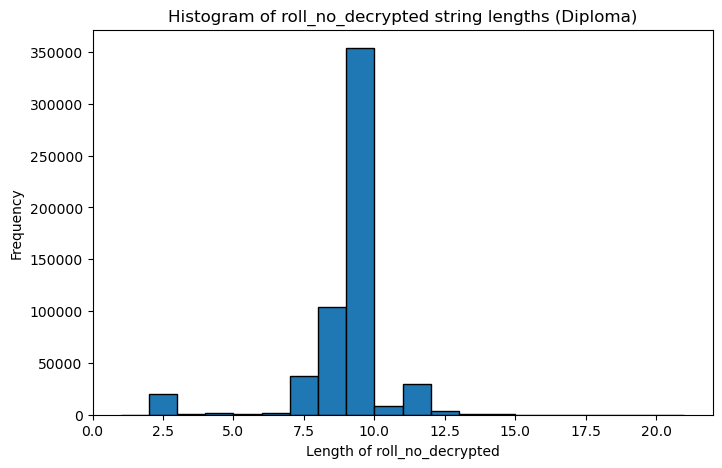

In [ ]:
import matplotlib.pyplot as plt
# built the histogram to check the string lenghth of roll no decrypted for diploma_df
# Calculate string lengths
lengths = iti_df["roll_no_decrypted"].astype(str).str.len()

plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=range(lengths.min(), lengths.max() + 2), edgecolor='black')
plt.xlabel("Length of roll_no_decrypted")
plt.ylabel("Frequency")
plt.title("Histogram of roll_no_decrypted string lengths (Diploma)")
plt.show()

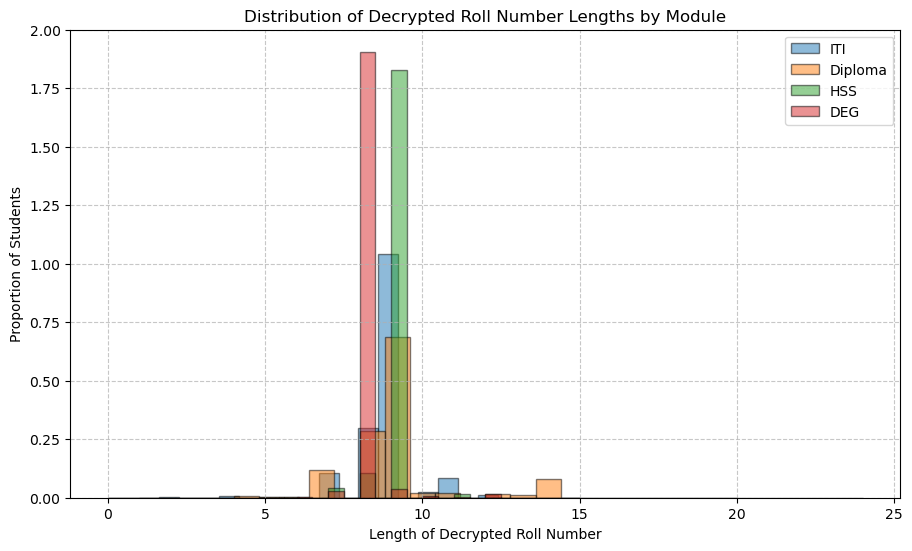

In [ ]:
# Compute decrypted roll number lengths for each module
lengths_data = {
    "ITI": iti_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
    "Diploma": diploma_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
    "HSS": hss_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
    "DEG": deg_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
}

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each module's length distribution as a histogram
for label, lengths in lengths_data.items():
    ax.hist(lengths, bins=30, alpha=0.5, label=label, edgecolor="black", density=True)

# Formatting
ax.set_title("Distribution of Decrypted Roll Number Lengths by Module")
ax.set_xlabel("Length of Decrypted Roll Number")
ax.set_ylabel("Proportion of Students")

# Set Y-axis ticks (e.g., 0%, 2%, ..., 10%)
yticks = np.arange(0, 0.12, 0.02)
# ax.set_yticks(yticks)
# ax.set_yticklabels([f"{int(y * 100)}%" for y in yticks])

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

# Add margin to avoid clipping left side
plt.subplots_adjust(left=0.12, right=0.95, top=0.9, bottom=0.12)

plt.show()


In [23]:
from IPython.display import display, display_html

# Step 1: Reuse your DB row counts
db_path = datasets["sams"]["path"]   
conn = sqlite3.connect(db_path)

query = """
SELECT
    module,
    academic_year,
    COUNT(*) AS total_count
FROM students
GROUP BY module, academic_year
"""
db_totals = pd.read_sql_query(query, conn)
conn.close()

In [24]:
def compute_missing_by_year(df, key_vars, module_name):
    """
    Returns a dataframe showing missing value counts per academic_year for key_vars, joined with DB total count.
    """
    results = []

    for var in key_vars:
        # Count missing by academic_year
        missing = (
            df.groupby('academic_year')[var]
            .apply(lambda x: x.isna().sum() + x.isin(["", "NA", "na"]).sum())
            .reset_index(name=var)
        )
        results.append(missing)

    # Merge all missing count columns together on academic_year
    merged = results[0]
    for r in results[1:]:
        merged = merged.merge(r, on='academic_year', how='outer')

    # Add total counts from DB
    db_counts = db_totals[db_totals["module"] == module_name]
    final = db_counts.merge(merged, on='academic_year', how='left')
    # Avoid inserting duplicate 'module' column
    if 'module' in final.columns:
        final = final.drop(columns=['module'])

    final.insert(0, 'module', module_name)
    return final


In [25]:
key_vars = ["student_name", "dob", "passing_year", "roll_no_decrypted", "examination_type", "exam_board"]

iti_missing = compute_missing_by_year(iti_df, key_vars, "ITI")
diploma_missing = compute_missing_by_year(diploma_df, key_vars, "Diploma")
hss_missing = compute_missing_by_year(hss_df, key_vars, "HSS")
deg_missing = compute_missing_by_year(deg_df, key_vars, "DEG")


In [26]:
display_html("<h3>ITI Variables Missing by Year</h3>", raw=True)
display(iti_missing)

display_html("<h3>Diploma Variables Missing by Year</h3>", raw=True)
display(diploma_missing)

display_html("<h3>HSS Variables Missing by Year</h3>", raw=True)
display(hss_missing)

display_html("<h3>DEG Variables Missing by Year</h3>", raw=True)
display(deg_missing)


ITI Variables Missing by Year

,module,academic_year,total_count,student_name,dob,passing_year,roll_no_decrypted,examination_type,exam_board
0,ITI,2017,34654,0,0,0,20254,0,0
1,ITI,2018,75211,0,0,0,37861,0,0
2,ITI,2019,64148,0,0,0,18950,0,0
3,ITI,2020,67415,0,0,0,14209,0,0
4,ITI,2021,68000,0,0,0,13792,0,0
5,ITI,2022,74104,0,0,0,12745,0,0
6,ITI,2023,92085,0,0,0,13272,0,0
7,ITI,2024,83958,0,0,0,9121,0,0


Diploma Variables Missing by Year

,module,academic_year,total_count,student_name,dob,passing_year,roll_no_decrypted,examination_type,exam_board
0,Diploma,2018,64218,0,0,0,34934,0,0
1,Diploma,2019,57824,0,0,0,19674,0,0
2,Diploma,2020,56600,0,0,0,16515,0,0
3,Diploma,2021,59278,0,0,0,13768,0,0
4,Diploma,2022,78196,0,0,0,15238,0,0
5,Diploma,2023,79700,0,0,0,11695,0,0
6,Diploma,2024,81789,0,0,0,10436,0,0


HSS Variables Missing by Year

,module,academic_year,total_count,student_name,dob,passing_year,roll_no_decrypted,examination_type,exam_board
0,HSS,2018,439528,0,0,0,32033,0,0
1,HSS,2019,411118,0,0,0,20221,0,0
2,HSS,2020,431636,0,0,0,16104,0,0
3,HSS,2021,498180,0,0,0,15083,0,0
4,HSS,2022,574238,0,0,0,14906,0,0
5,HSS,2023,560769,0,0,2,8680,0,0
6,HSS,2024,537932,0,0,0,8700,0,0


DEG Variables Missing by Year

,module,academic_year,total_count,student_name,dob,passing_year,roll_no_decrypted,examination_type,exam_board
0,DEG,2018,312823,0,0,0,986,0,0
1,DEG,2019,254342,0,0,0,1389,0,0
2,DEG,2020,242661,0,0,0,1522,0,0
3,DEG,2021,264152,0,0,0,1263,0,0
4,DEG,2022,379911,0,0,0,1136,0,0
5,DEG,2023,289849,0,0,0,30,0,0
6,DEG,2024,310753,0,0,0,44,0,0


In [ ]:
with pd.ExcelWriter("missing_key_field.xlsx", engine="openpyxl") as writer:
    # Write ITI first
    iti_missing.to_excel(writer, sheet_name="Missing by Year", startrow=1, index=False)
    worksheet = writer.sheets["Missing by Year"]
    worksheet.cell(row=1, column=1).value = "ITI Variables Missing by Year"

    # Write Diploma below ITI
    startrow = len(iti_missing) + 4
    diploma_missing.to_excel(writer, sheet_name="Missing by Year", startrow=startrow, index=False)
    worksheet.cell(row=startrow, column=1).value = "Diploma Variables Missing by Year"

    # Write HSS below Diploma
    startrow += len(diploma_missing) + 3
    hss_missing.to_excel(writer, sheet_name="Missing by Year", startrow=startrow, index=False)
    worksheet.cell(row=startrow, column=1).value = "HSS Variables Missing by Year"

    # Write DEG below HSS
    startrow += len(hss_missing) + 3
    deg_missing.to_excel(writer, sheet_name="Missing by Year", startrow=startrow, index=False)
    worksheet.cell(row=startrow, column=1).value = "DEG Variables Missing by Year"


In [148]:
def encode_part(s: pd.Series, *, na_label="NA", missing_label="MISSING", lower=False) -> pd.Series:
    """
    Encode parts of a student key by handling missing/NA values consistently.
    """
    is_nan = s.isna()
    t = s.astype(str).str.strip()
    t = t.str.strip('"').str.strip("'")   # remove quotes if present

    out = t.copy()

    # Replace explicit NA and missing values
    out = out.mask(t.eq("NA"), na_label)
    out = out.mask(t.eq("") | is_nan, missing_label)

    # Normalize casing if requested
    if lower:
        out = out.where(out.isin([na_label, missing_label]), out.str.lower().str.strip())

    return out


In [149]:
def generate_student_key_df(df, module_name: str) -> pd.DataFrame:
    """
    Clean key columns in-place, then generate a student_key
    and print diagnostics about duplicates.
    """
    new_df = df.copy()

    # Columns used for the key
    key_vars = ["student_name", "passing_year", "dob",
                "roll_no_decrypted", "exam_board", "examination_type"]

    # Normalize these columns 
    for col in key_vars:
        new_df[col] = encode_part(new_df[col], lower=True)

    # Construct student key explicitly
    new_df["student_key"] = (
        new_df["student_name"] + "_" +
        new_df["passing_year"] + "_" +
        new_df["dob"] + "_" +
        new_df["roll_no_decrypted"] + "_" +
        new_df["exam_board"] + "_" +
        new_df["examination_type"]
    )

    # Diagnostics
    total_records = len(new_df)
    unique_aadhar = new_df["aadhar_no"].nunique()
    unique_keys = new_df["student_key"].nunique()

    # Problematic duplicates = same key linked to multiple Aadhaar numbers
    dup_check = (
        new_df.groupby("student_key")["aadhar_no"]
        .nunique(dropna=True)
        .reset_index(name="unique_aadhar_count")
    )
    problematic_keys = dup_check[dup_check["unique_aadhar_count"] > 1]["student_key"]

    # Count of problematic duplicate keys
    duplicate_keys_count = len(problematic_keys)

    # Count of rows affected by those problematic keys
    # duplicate_rows_count = new_df[new_df["student_key"].isin(problematic_keys)].shape[0]

    print(f"\n[{module_name}]")
    print("Total student records:", total_records)
    print("Unique Aadhaar numbers:", unique_aadhar)
    print("Unique student keys generated:", unique_keys)
    print("Duplicate student keys:", duplicate_keys_count)
    # print("Total rows having duplicate keys:", duplicate_rows_count)

    return new_df


In [150]:
# Generate student key datasets
iti_key_df = generate_student_key_df(iti_df, "ITI")
diploma_key_df = generate_student_key_df(diploma_df, "Diploma")
hss_key_df = generate_student_key_df(hss_df, "HSS")
deg_key_df = generate_student_key_df(deg_df, "DEG")


[ITI]
Total student records: 559575
Unique Aadhaar numbers: 518025
Unique student keys generated: 524797
Duplicate student keys: 1807

[Diploma]
Total student records: 477605
Unique Aadhaar numbers: 417756
Unique student keys generated: 445275
Duplicate student keys: 4320

[HSS]
Total student records: 3453401
Unique Aadhaar numbers: 2650769
Unique student keys generated: 2961052
Duplicate student keys: 5011

[DEG]
Total student records: 2054491
Unique Aadhaar numbers: 1506304
Unique student keys generated: 1634565
Duplicate student keys: 1917


In [36]:
# Final processed datasets
print("Diploma dataset shape:", diploma_key_df.shape)
print("ITI dataset shape:", iti_key_df.shape)

# Preview duplicates
# diploma_key_df[diploma_key_df["student_key"].isin(
#     diploma_key_df["student_key"].value_counts()[lambda x: x > 1].index
# )]

iti_key_df[iti_key_df["student_key"].isin(
    iti_key_df["student_key"].value_counts()[lambda x: x > 1].index
)].head()

Diploma dataset shape: (558879, 13)
ITI dataset shape: (559575, 13)


,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,passing_year,roll_no,examination_type,exam_board,roll_no_decrypted,student_key
0,7404718,2017,17T0181047,DeGxV1bCBqOBygfLzt3u268Es6xBaRZq3tf+eEp6WDw=,AKASH GARNAYAK,01-Jan-2002,10TH,"""2017""","""PoLOLFcCUYZ/iR42DWBy2A==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",105AE0003,akash garnayak_2017_01-jan-2002_105ae0003_boar...
2,7404720,2017,17T0346747,EPFmTPfdOGPrc/oLdkNxJ+t1ocsxYmM+j+/2AL7aEBQ=,ANIL MOHARANA,07-Oct-2001,10TH,"""2017""","""LjH/WJQkl9UJzVJCu+CaSQ==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",170AF0002,anil moharana_2017_07-oct-2001_170af0002_board...
4,7404722,2017,17T0151332,5HZd0Oz9ono6DBV2LKOoQiVGsyUreUWNxVEOdVgcrcs=,BABULI MAJHI,20-Apr-1999,12 TH,"""2014""","""BpFNV6ZmrmdtbEcHJS6eGg==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",NA,babuli majhi_2014_20-apr-1999_NA_board of seco...
5,7404723,2017,17T0368940,kE8pjcVYaloR8h7MHt9Lvf69OKmOVQlAXCsPWNMy72o=,BHAKTA TUDU,21-Feb-1999,10TH,"""2015""","""5IvZQeYaKHJj3t5Mz1hGdQ==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",NA,bhakta tudu_2015_21-feb-1999_NA_board of secon...
7,7404725,2017,17T03659610,AM1BwT3d2R+NQ2nuBdCHt4Qhw83J+GG5svrRrRWvjrE=,BISWAJIT BEHERA,14-Mar-2002,,"""2017""","""ygiPoVgEWXgegbZaYL66Aw==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",105AE0018,biswajit behera_2017_14-mar-2002_105ae0018_boa...


In [37]:
def enrollment_key_summary(df, module_name: str = None):
    """
    Generate per-year aggregates of enrollment, Aadhaar, and student keys.
    Includes totals and differences to flag duplicates/mismatches.
    """
    grp = df.groupby("academic_year")

    summary = pd.concat([
        grp["aadhar_no"].count().rename("total_enrolled"),
        # grp["aadhar_no"].nunique().rename("unique_aadhar"),
        grp["student_key"].nunique().rename("unique_student_keys"),
    ], axis=1).reset_index()

    # Differences
    # summary["diff_enroll_vs_aadhar"] = summary["total_enrolled"] - summary["unique_aadhar"]
    summary["diff_enroll_vs_keys"] = summary["total_enrolled"] - summary["unique_student_keys"]
    # summary["diff_aadhar_vs_keys"] = summary["unique_aadhar"] - summary["unique_student_keys"]

    # Add totals row
    totals = {
        "academic_year": "All Years",
        "total_enrolled": summary["total_enrolled"].sum(),
        # "unique_aadhar": summary["unique_aadhar"].sum(),
        "unique_student_keys": summary["unique_student_keys"].sum(),
        # "diff_enroll_vs_aadhar": summary["diff_enroll_vs_aadhar"].sum(),
        "diff_enroll_vs_keys": summary["diff_enroll_vs_keys"].sum(),
        # "diff_aadhar_vs_keys": summary["diff_aadhar_vs_keys"].sum(),
    }
    summary = pd.concat([summary, pd.DataFrame([totals])], ignore_index=True)

    if module_name:
        print(f"\n[{module_name}] Enrollment & Stats")
    return summary

In [38]:
iti_enrollment_summary = enrollment_key_summary(iti_key_df, "ITI")
iti_enrollment_summary


[ITI] Enrollment & Stats


,academic_year,total_enrolled,unique_student_keys,diff_enroll_vs_keys
0,2017,34654,29989,4665
1,2018,75211,71194,4017
2,2019,64148,64133,15
3,2020,67415,67413,2
4,2021,68000,67987,13
5,2022,74104,74090,14
6,2023,92085,92077,8
7,2024,83958,83958,0
8,All Years,559575,550841,8734


In [39]:
hss_enrollment_summary = enrollment_key_summary(hss_key_df, "HSS")
hss_enrollment_summary


[HSS] Enrollment & Stats


,academic_year,total_enrolled,unique_student_keys,diff_enroll_vs_keys
0,2018,387069,410424,-23355
1,2019,375768,387103,-11335
2,2020,374368,394490,-20122
3,2021,403448,446480,-43032
4,2022,491504,482548,8956
5,2023,479176,480728,-1552
6,2024,520066,487117,32949
7,All Years,3031399,3088890,-57491


In [ ]:
hss_key_df

In [53]:
# Count total rows per key
key_counts = hss_key_df["student_key"].value_counts()

# Count unique Aadhaar per key
aadhar_counts = hss_key_df.groupby("student_key")["aadhar_no"].nunique(dropna=True)

# Keep only keys that repeat and link to >1 Aadhaar
problematic_keys = key_counts[(key_counts > 1) & (aadhar_counts > 1)]

print("Total problematic duplicate keys:", len(problematic_keys))
problematic_keys.head()

Total problematic duplicate keys: 5011


student_key
nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2018.0_2002-12-20_6120996_cbse, new delhi_annual         8
aiagpi2hyf/l5d6dirzrjae9jlpc04jo9bgr357lx2g=_2020.0_2002-01-17_146cd0049_bse, odisha_supplementary    7
2imr0jd1w89i1avouwr5s7k7ogd5mpgfxd/ngpxq0lu=_2020.0_2004-02-13_042ef0079_bse, odisha_annual           6
3ejnstxwrqf7xo2l0wsxbmmvhge1odfw2htrupf/hnm=_2021.0_2005-08-07_206eg0058_bse, odisha_annual           6
zwikl1d9wcz2sudl41ltzinq+asldttg8uy9wam8+ua=_2021.0_2005-04-15_034fd0265_bse, odisha_annual           6
Name: count, dtype: int64

In [51]:
def get_problematic_duplicates_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a DataFrame of only problematic duplicate keys:
    - Keys that appear >1
    - And are linked to multiple Aadhaar numbers
    Sorted by most repeated key first.
    """
    # Count occurrences per student_key
    key_counts = df["student_key"].value_counts()

    # Count unique Aadhaar per student_key
    aadhar_counts = (
        df.groupby("student_key")["aadhar_no"]
          .nunique(dropna=True)   # ignore NaN Aadhaar
    )

    # Keep only problematic keys (repeated AND >1 Aadhaar number)
    problematic_keys = key_counts[(key_counts > 1) & (aadhar_counts > 1)]

    # Subset the original df for only those keys
    dup_df = df[df["student_key"].isin(problematic_keys.index)].copy()

    # Add helper columns
    dup_df["dup_count"] = dup_df["student_key"].map(problematic_keys)
    dup_df["unique_aadhar_count"] = dup_df["student_key"].map(aadhar_counts)

    # Sort: most repeats first, then by key, Aadhaar, sams_id, year
    dup_df = dup_df.sort_values(
        by=["dup_count", "unique_aadhar_count", "student_key", "aadhar_no", "sams_id", "academic_year"],
        ascending=[False, False, True, True, True, True]
    )

    return dup_df

dup_df = get_problematic_duplicates_df(hss_key_df)

# See first few problematic duplicates
dup_df.head()


,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,passing_year,roll_no,examination_type,exam_board,roll_no_decrypted,student_key,dup_count,unique_aadhar_count
481853,2484796,2019,19J3116024,"à9,!÷ïf5:ük¥`ýfç öæ«ýâ ¯qrévsø§t",nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=,2002-12-20,10TH,2018.0,p74r23S6h+TZ90rZENSxhA==,annual,"cbse, new delhi",6120996,nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2...,8,2
523105,2526048,2019,19J3551304,"à9,!÷ïf5:ük¥`ýfç öæ«ýâ ¯qrévsø§t",nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=,2002-12-20,10TH,2018.0,p74r23S6h+TZ90rZENSxhA==,annual,"cbse, new delhi",6120996,nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2...,8,2
533669,2536612,2019,19J3667823,"à9,!÷ïf5:ük¥`ýfç öæ«ýâ ¯qrévsø§t",nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=,2002-12-20,10TH,2018.0,p74r23S6h+TZ90rZENSxhA==,annual,"cbse, new delhi",6120996,nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2...,8,2
550696,2553639,2019,19J3861714,"à9,!÷ïf5:ük¥`ýfç öæ«ýâ ¯qrévsø§t",nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=,2002-12-20,10TH,2018.0,p74r23S6h+TZ90rZENSxhA==,annual,"cbse, new delhi",6120996,nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2...,8,2
1124691,3369066,2020,20J3716752,"à9,!÷ïf5:ük¥`ýfç öæ«ýâ ¯qrévsø§t",nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=,2002-12-20,10TH,2018.0,p74r23S6h+TZ90rZENSxhA==,annual,"cbse, new delhi",6120996,nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2...,8,2
